## Import and Inspect Data

In [2]:
import pandas as pd
import numpy as np

In [48]:
# For a quick look at beginning and end of series.

def ends(df, x=3):
    dots = pd.Series(['...'],index=['...'])
    print(str(len(df))+' elements. Printing first '+str(x)+' and last '+str(x))
    return df.head(x).append(dots).append(df.tail(x))

In [3]:
X = pd.read_csv('Data/training_values.csv')

In [4]:
df = X.merge(pd.read_csv('Data/training_labels.csv'),on='id')

In [712]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

As we can see, there are a lot of variables. Some have a lot of null values as well. Also many of these variables are strings. Some of which may be useful categorical data.

Descriptions of the variables can be found here: 
https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list

The label data is distributed in three categories: 'functional', 'functional needs repair', and 'non-functional'.

In [713]:
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In the next cell we see the number of unique values in each string column. Categorical variables with a small number of values could be low hanging fruit in terms of finding ways to seperate the data. For example, there is a basin variable with only 9 categories. Perhaps some basins have better performing wells than others.

In [20]:
str_variables = df.dtypes[df.dtypes == 'object'].index

df[str_variables].nunique()

date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

## Analysis

Countplots, also known as bar graphs, may help identify useful variables.

We can also use some simple aggregation to gain insights

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

Wells with a spring, river or rain source appear to function more reliably than other sources such as shallow wells and deep bore holes.

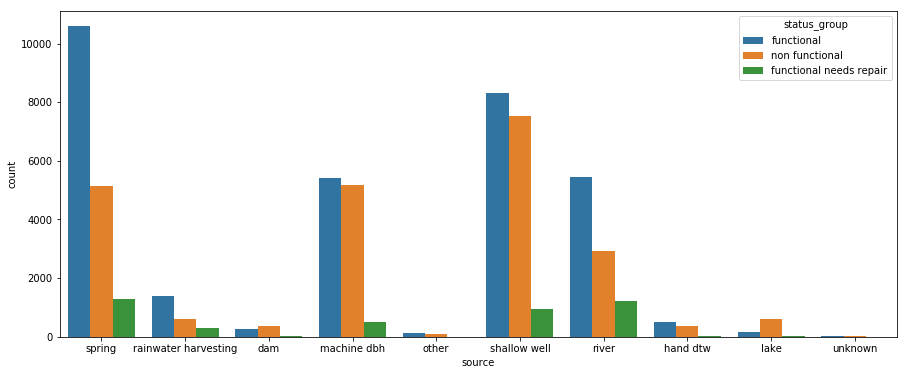

In [716]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='source',hue='status_group',data=df)

Having a permit does not appear to affect well function

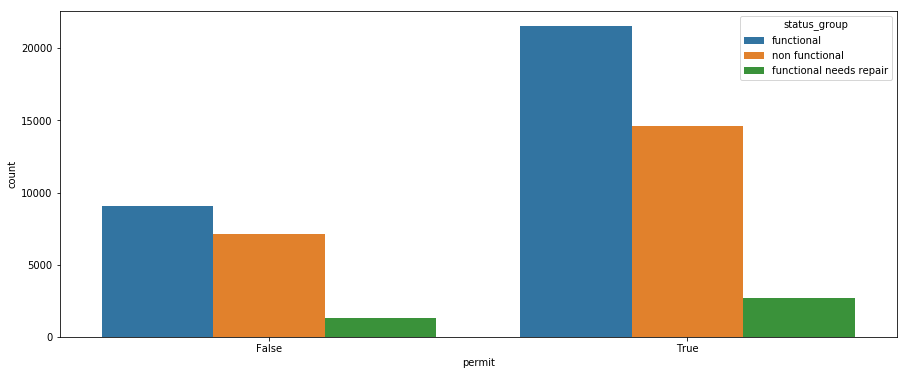

In [68]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='permit',hue='status_group',data=df)

Gravity and hand pump extraction types seem to be most reliable. This seems reasonable consideringt the mechanism is much simpler. This seems useful but there could be collinearity with the source variable as well.

I am not very familiar with pumps in general, but I found a short article that wasa good introduction.

https://www.hometips.com/articles/submersible-water-pumps.html

The article mentioned that submersible pumps generally last 20-25 years. It also stated that cloud or dirty water can be an indicator of imminent pump failure (the sediment damages the pump).

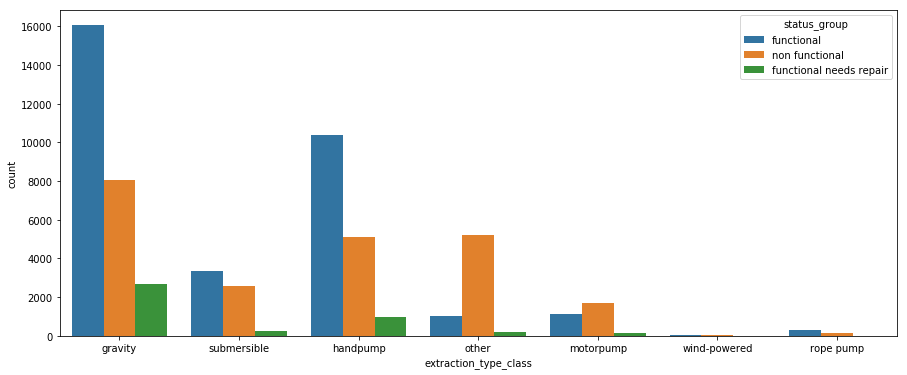

In [14]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='extraction_type_class',hue='status_group',data=df)

The next plot shows that some basins do have better well function than others. 

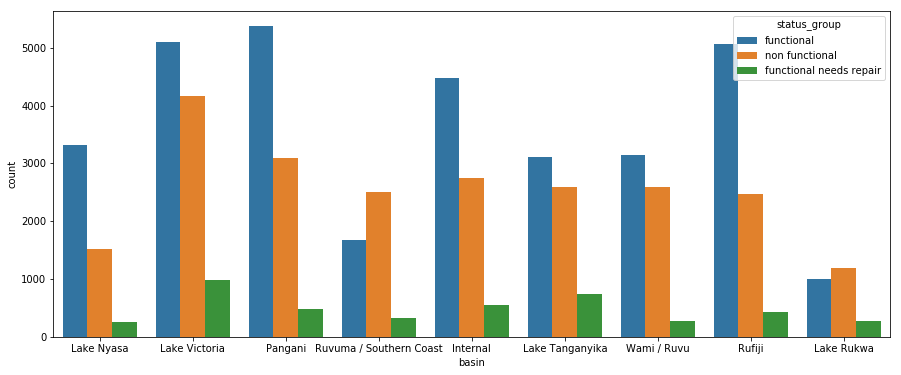

In [15]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='basin',hue='status_group',data=df)

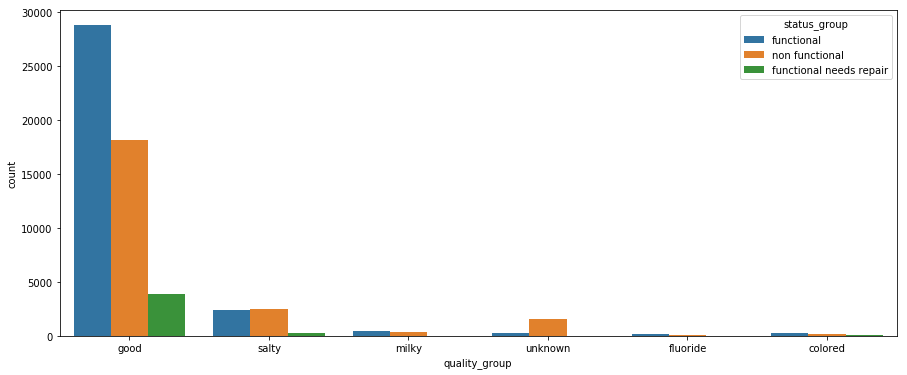

In [16]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='quality_group',hue='status_group',data=df)

In [11]:
print('Wells with marginal water quality: '+ str(len(df[df.quality_group != 'good'])))
print('Wells with good water quality:     '+ str(len(df[df.quality_group == 'good'])))

Wells with marginal water quality: 8582
Wells with good water quality:     50818


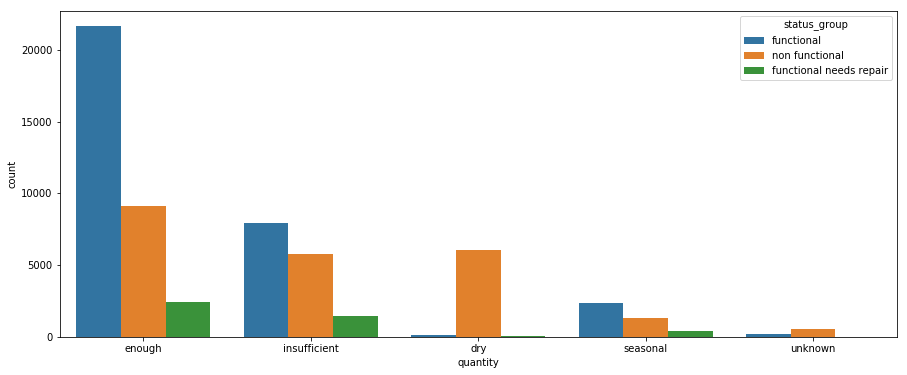

In [17]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='quantity',hue='status_group',data=df)

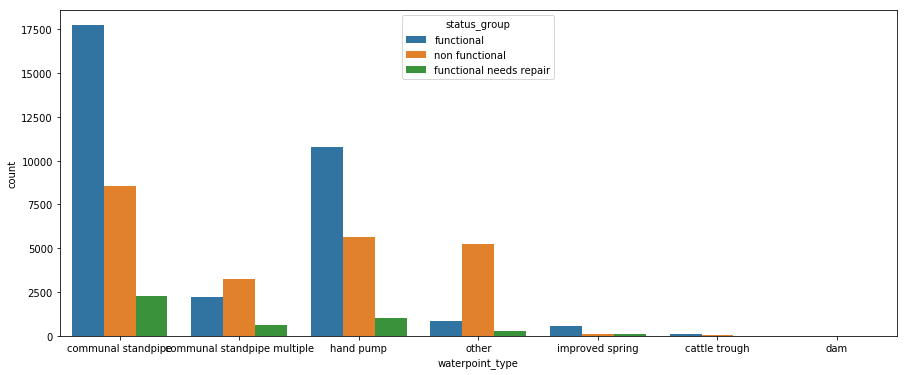

In [18]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='waterpoint_type',hue='status_group',data=df)

Here's a slight problem, over 20,000 wells have a construction year of zero. Could this mean the wells are very old? Or simply that the year of construction is unknown? The two count plots below show that these wells tend to use simple extraction methods (gravity or handpump) and that they are almost entirely located in six regions. The most reasonable conclusion is that this data was not avaiable or not collected in these regions.

In [46]:
ends(df.construction_year.value_counts())

55 elements. Printing first 3 and last 3


0       20709
2010     2645
2008     2613
...       ...
1961       21
1965       19
1966       17
dtype: object

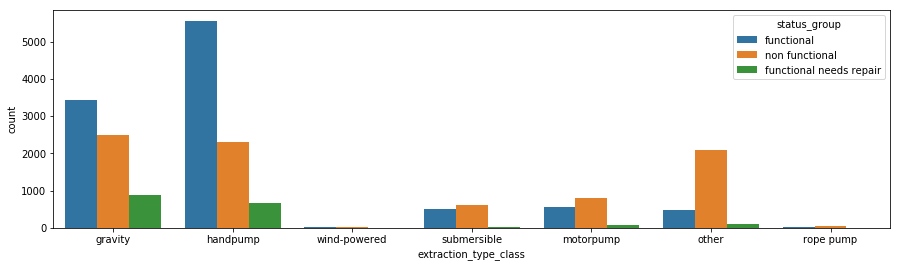

In [61]:
plt.figure(figsize=(15,4))
ax = sns.countplot(x='extraction_type_class',hue='status_group',data=df[df.construction_year==0])

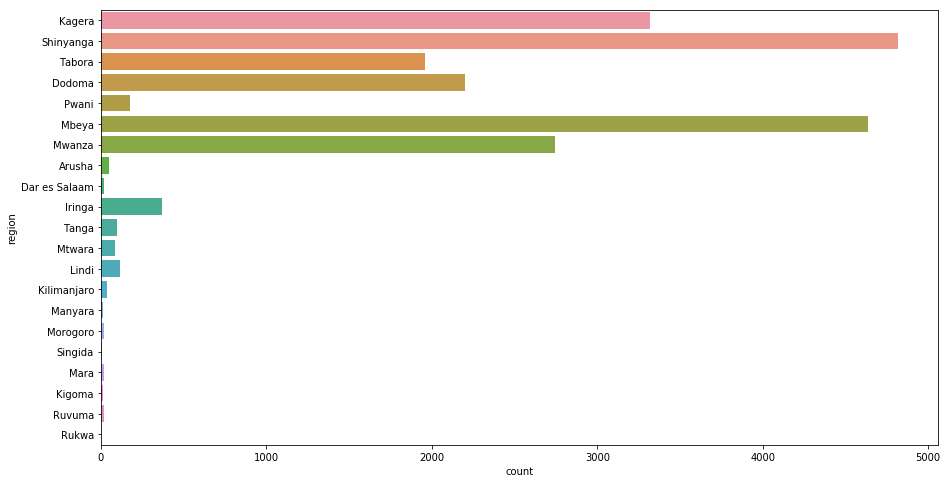

In [59]:
plt.figure(figsize=(15,8))
ax = sns.countplot(y='region',data=df[df.construction_year==0])

As we see in these boxplots, construction_year could beuseful, however we would have to do something about the missing data and the fact that it is missing in specific regions. We may later choose to make two different models, onefor the six regions with the bulk of the missing age data and another for the rest.

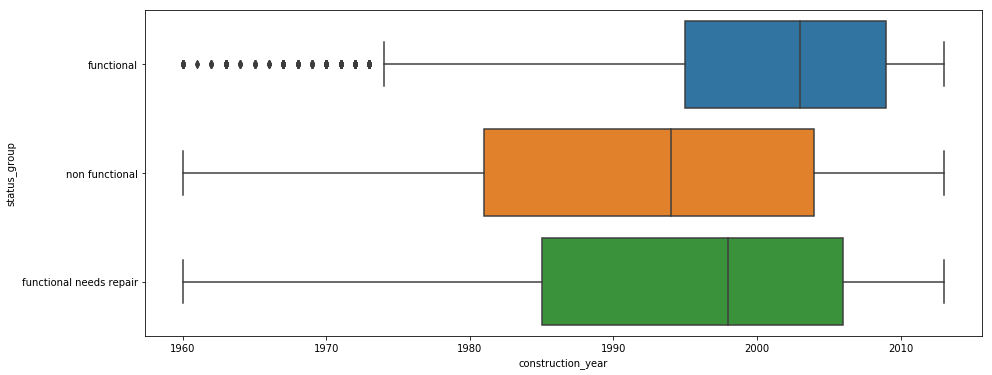

In [66]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x='construction_year',y='status_group',data=df[df.construction_year!=0])

Box plots of population data are not useful at first. There appear to bemany many small population values.

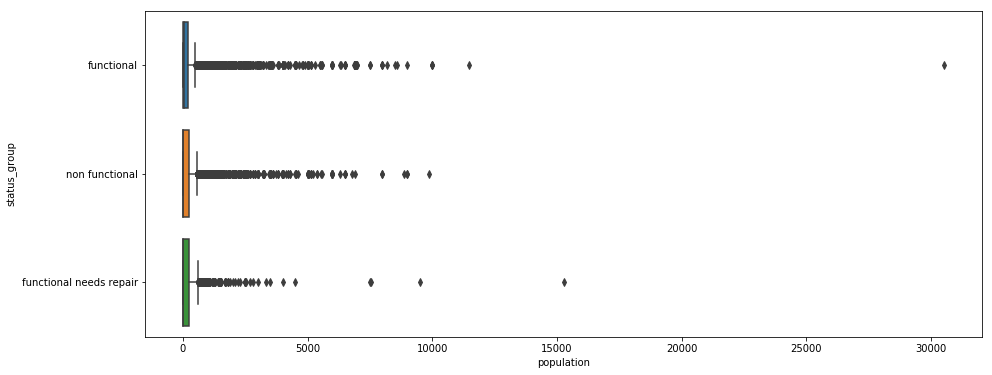

In [112]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x='population',y='status_group',data=df)

Now we see that over 28,000 populatin values are zero or one. This is not realistic.

In [94]:
len(df[df.population==0])

21381

In [118]:
len(df[df.population==1])

7025

In [123]:
logP = pd.concat([np.log10(df[df.population>1].population),df[df.population>1].status_group],axis=1)
logP.head()

,population,status_group
0,2.037426,functional
1,2.447158,functional
2,2.397940,functional
3,1.763428,non functional
10,2.537819,functional


In [124]:
len(logP)

30994

By removing the zeros and ones and taking the log we see that well function is actually quite consistent across various magnitudes of population.

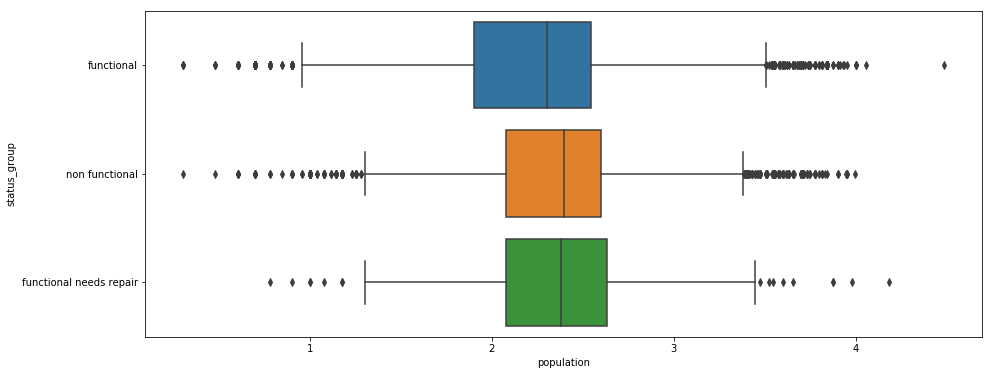

In [125]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x='population',y='status_group',data=logP)

We're seeing an unfortunate pattern in the numeric data. Much of it has a value of zero. This includes the total static head pressure values. I don't know enough about this type of measurement to make use of it.

In [127]:
len(df[df.amount_tsh==0])

41639

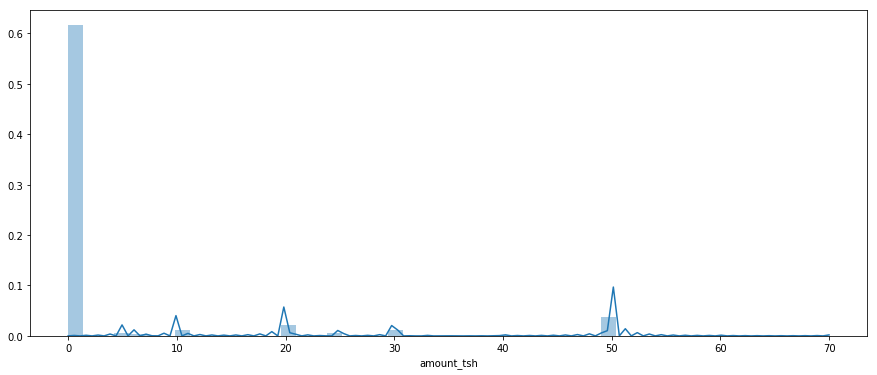

In [132]:
plt.figure(figsize=(15,6))
ax = sns.distplot(df[df.amount_tsh<100].amount_tsh)

GPS data is also suspect

In [134]:
len(df[df.gps_height==0])

20438

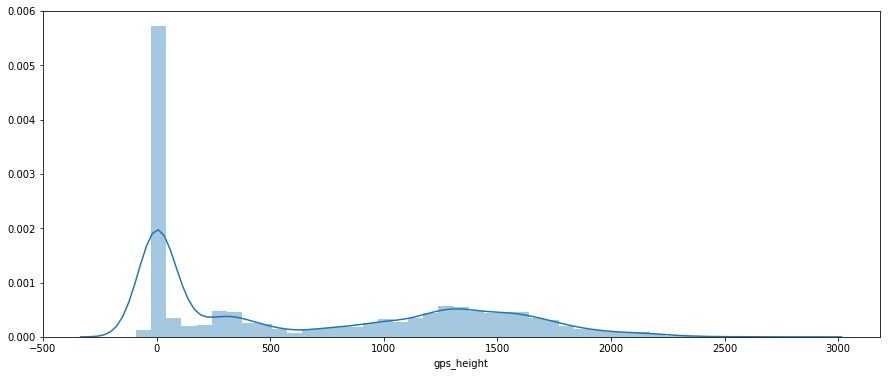

In [133]:
plt.figure(figsize=(15,6))
ax = sns.distplot(df.gps_height)

## Simplification

Let's see how well we can model the outcome with a simpler data set using the following adjustments:

* no continous data or time data, because there is so much missing
* one hot encodings of some categorical data that seems promising.
* convert the label data into 1: 'functioning' (including 'needs repair') and 0: 'not functioning' 

In [140]:
categoricals = df.nunique().to_frame()
categoricals.columns = ['nUnique']
categoricals[categoricals.nUnique<30]

,nUnique
basin,9
region,21
region_code,27
district_code,20
public_meeting,2
recorded_by,1
scheme_management,12
permit,2
extraction_type,18
extraction_type_group,13


Many variables or variables with many categories will lead to a large number of dummy clumns after one hot encoding. This can make the NN harder to train. So let's just pick a few out.

waterpoint_type, quantity, extraction_type_class, and basin

In [143]:
categoricals = ['basin','extraction_type_class','quantity','waterpoint_type']

In [144]:
df[categoricals].nunique()

basin                    9
extraction_type_class    7
quantity                 5
waterpoint_type          7
dtype: int64

## Creating a one hot encoding data frame

We need one hot encoding (binary dummies) for any categorical that has more than 2 states (all of the ones we kept actually). This way the NN doesn't try to do arithmetic with values that are categorical.

In [145]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [146]:
le = LabelEncoder()
df2 = df[categoricals].apply(le.fit_transform)
df2.head()

,basin,extraction_type_class,quantity,waterpoint_type
0,1,0,1,1
1,4,0,2,1
2,5,0,1,2
3,7,5,0,2
4,4,0,3,1


In [147]:
enc = OneHotEncoder()
enc.fit(df2)
onehotarray = enc.transform(df2).toarray()
onehotarray.shape

(59400, 28)

In [150]:
df3 = pd.DataFrame(onehotarray)
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [151]:
len(df3)

59400

Looks like we have all the data we wanted, represented as dummy variables. Tensorflow requires strings for column names.

In [152]:
df3.columns = [str(l) for l in df3.columns]
df3.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27'],
      dtype='object')

## Create a numeric version of the status_group

In [153]:
le_y = LabelEncoder()
y = pd.Series(le_y.fit_transform(df.status_group))
y = y.map({0:1,1:1,2:0})

In [154]:
len(y)

59400

## Construct a Neural Network

In [155]:
import tensorflow as tf
from sklearn.model_selection import train_test_split as tts

In [156]:
X_train,X_test,y_train,y_test = tts(df3,y,test_size=0.3)

In [157]:
feature_cols = []
for col in X_train.columns:
    feature_cols.append(tf.feature_column.numeric_column(col))

In [178]:
batchsize = 20
nsteps = 400

In [179]:
input_fx = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=batchsize,num_epochs=4,shuffle=True)

In [180]:
classifier = tf.estimator.DNNClassifier(hidden_units=[10,10],n_classes=2,feature_columns=feature_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\James\\AppData\\Local\\Temp\\tmpak208522', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026237401828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [181]:
classifier.train(input_fn=input_fx,steps=nsteps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\James\AppData\Local\Temp\tmpak208522\model.ckpt.
INFO:tensorflow:loss = 13.653252, step = 1
INFO:tensorflow:global_step/sec: 310.802
INFO:tensorflow:loss = 9.962747, step = 101 (0.322 sec)
INFO:tensorflow:global_step/sec: 350.467
INFO:tensorflow:loss = 11.482075, step = 201 (0.285 sec)
INFO:tensorflow:global_step/sec: 349.417
INFO:tensorflow:loss = 12.2602, step = 301 (0.286 sec)
INFO:tensorflow:Saving checkpoints for 400 into C:\Users\James\AppData\Local\Temp\tmpak208522\model.ckpt.
INFO:tensorflow:Loss for final step: 12.826591.


## Evaluate

In [182]:
pred_fx = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)

In [183]:
probs = list(classifier.predict(input_fn=pred_fx))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\James\AppData\Local\Temp\tmpak208522\model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [184]:
predictions = []
for p in probs:
    predictions.append(p['class_ids'][0])

In [185]:
(predictions == y_test).mean()

0.774354657687991

In [186]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 3462  3419]
 [  602 10337]]


             precision    recall  f1-score   support

          0       0.85      0.50      0.63      6881
          1       0.75      0.94      0.84     10939

avg / total       0.79      0.77      0.76     17820



## Conclusion

The neural network is 85% accurate when it identifies a well as not functional. However, it only finds 50% of these broken wells. It is slightly less precise in identifying working wells, but finds 94% of that group. The f1-score of 0.76 indicates that this NN has some useful predictive power.

## Possible Improvements

* Our model predicts functinal vs not functional. Ideally we also would predict functioning well that need repairs as a third category.

* Many columns were discarded due to missing or nonsense values. We could have discarded the offending rows instead and this may lead to a better model. This could be especially useful for the age data. 

* We have also not made use of some of the fine detail of the location data. Consider the plot below as a clue to how location may offer some predictive insight (notice the clustering).

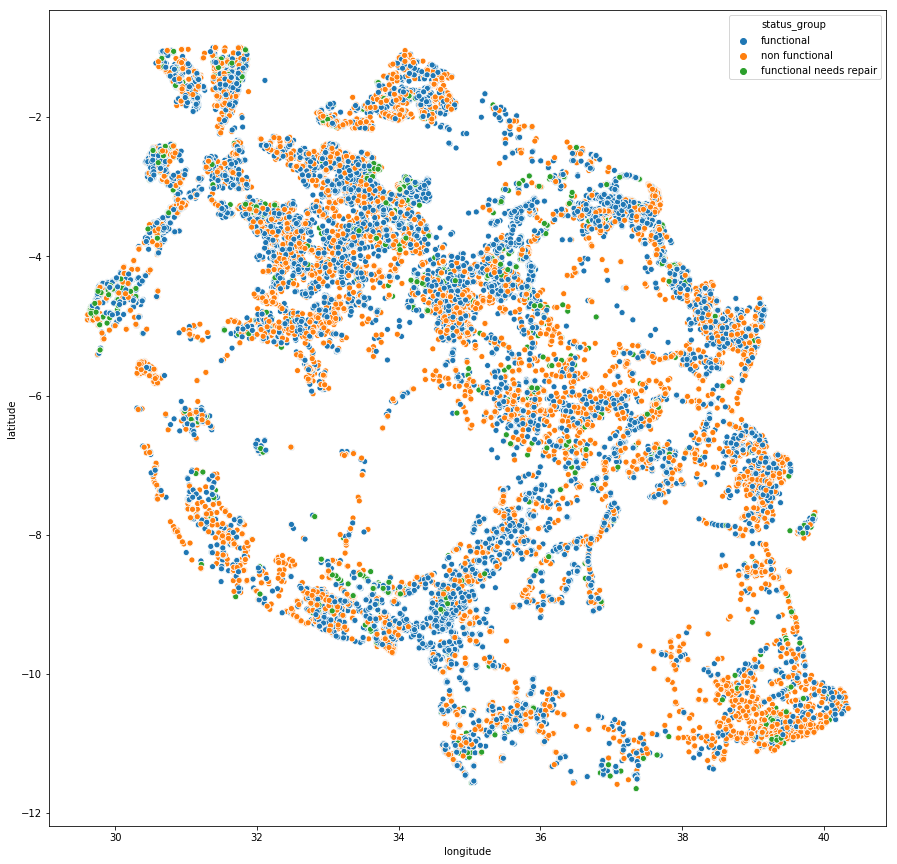

In [191]:
plt.figure(figsize=(15,15))
ax = sns.scatterplot(x='longitude',y='latitude',data=df[df.longitude>25],hue='status_group')